In [1]:
import os
import pandas as pd
import numpy as np
from xgboost import XGBRegressor
from tqdm import tqdm

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Zusätzliche Importe für Analyse und Visualisierung
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf

# Funktion zur Datenbereinigung
def clean_data(df, is_train=True):
    """
    Bereinigt den DataFrame:
    - Ersetzt fehlende Werte (NaN) mit sinnvollen Standardwerten.
    - Entfernt problematische Spaltennamen.
    - Wandelt kategorische Spalten in numerische Werte um.
    """
    df.fillna(0, inplace=True)
    df.columns = df.columns.str.replace(r"[^a-zA-Z0-9_]", "_", regex=True)
#     for col in df.columns:
#        if df[col].dtype == 'object':
#            df[col] = df[col].astype(str).astype('category').cat.codes
    return df


# Aktuelles Arbeitsverzeichnis abrufen
current_dir = os.getcwd().replace("\\", "/")

# Einlesen der Trainings- und Testdaten
train_path = os.path.join(current_dir, "data/train.csv")
test_path = os.path.join(current_dir, "data/test.csv")
df_train = pd.read_csv(train_path)
df_test = pd.read_csv(test_path)

# Daten bereinigen
df_train = clean_data(df_train, is_train=True)
df_test = clean_data(df_test, is_train=False)
# Abstimmen der Columns in df_test auf die von df_train
missing_cols = set(df_train.columns) - set(df_test.columns)
for col in missing_cols:
    df_test[col] = 0
extra_cols = set(df_test.columns) - set(df_train.columns)
df_test = df_test.drop(columns=extra_cols)
df_test = df_test[df_train.columns]
# ---------------------------
# Analyse: Einfluss von "race_group" und "age_at_hct" auf den EFS Score
# ---------------------------
print("Analysiere Zusammenhänge zwischen 'race_group', 'age_at_hct' und EFS Score...")
# Stelle sicher, dass "race_group" als kategorial interpretiert wird
df_train['race_group'] = df_train['race_group'].astype('category')
# OLS-Regression durchführen
model = smf.ols("efs ~ age_at_hct + C(race_group)", data=df_train).fit()
print(model.summary())




Analysiere Zusammenhänge zwischen 'race_group', 'age_at_hct' und EFS Score...
                            OLS Regression Results                            
Dep. Variable:                    efs   R-squared:                       0.058
Model:                            OLS   Adj. R-squared:                  0.058
Method:                 Least Squares   F-statistic:                     294.3
Date:                Mon, 24 Feb 2025   Prob (F-statistic):               0.00
Time:                        21:50:56   Log-Likelihood:                -19956.
No. Observations:               28800   AIC:                         3.993e+04
Df Residuals:                   28793   BIC:                         3.998e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                                                                 coef    std err          t      P>|t|      [0.025      0.975]
-----

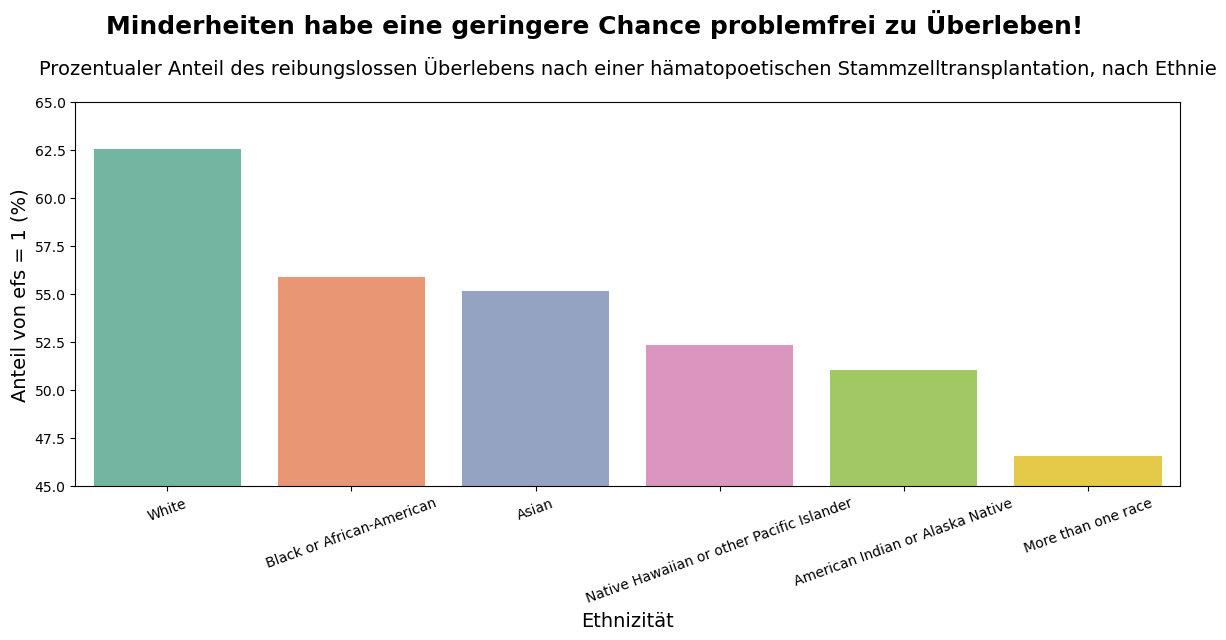

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

# Stelle sicher, dass "race_group" als Kategorie interpretiert wird
df_train['race_group'] = df_train['race_group'].astype('category')

# Gruppiere nach race_group und berechne die Gesamtanzahl und die Anzahl der Fälle, bei denen efs == 1.0 gilt
group_data = df_train.groupby('race_group').agg(
    total=('efs', 'count'),
    count_efs1=('efs', 'sum')
).reset_index()

# Berechne den prozentualen Anteil
group_data['percentage'] = group_data['count_efs1'] / group_data['total'] * 100

# Ermittele die Reihenfolge der Race Groups, sortiert nach absteigendem Prozentwert
ordered_groups = group_data.sort_values(by='percentage', ascending=False)['race_group']

# Erstelle einen Balkenplot
plt.figure(figsize=(12, 6))
ax = sns.barplot(x='race_group', y='percentage', data=group_data, order=ordered_groups, palette="Set2")

# Setze y-Achsenbegrenzung auf 50-60%
ax.set_ylim(45, 65)

# Setze Achsenbeschriftungen und Titel
ax.set_xlabel("Ethnizität", fontsize=14)
ax.set_ylabel("Anteil von efs = 1 (%)", fontsize=14)
ax.set_title("Prozentualer Anteil des reibungslossen Überlebens nach einer hämatopoetischen Stammzelltransplantation, nach Ethnie", fontsize=14, pad=20)
plt.suptitle("Minderheiten habe eine geringere Chance problemfrei zu Überleben!", y=0.90, fontsize=18, fontweight="bold")

# Passe das Layout an
plt.tight_layout(rect=[0, 0, 1, 0.92])

plt.xticks(rotation = 20)
plt.show()

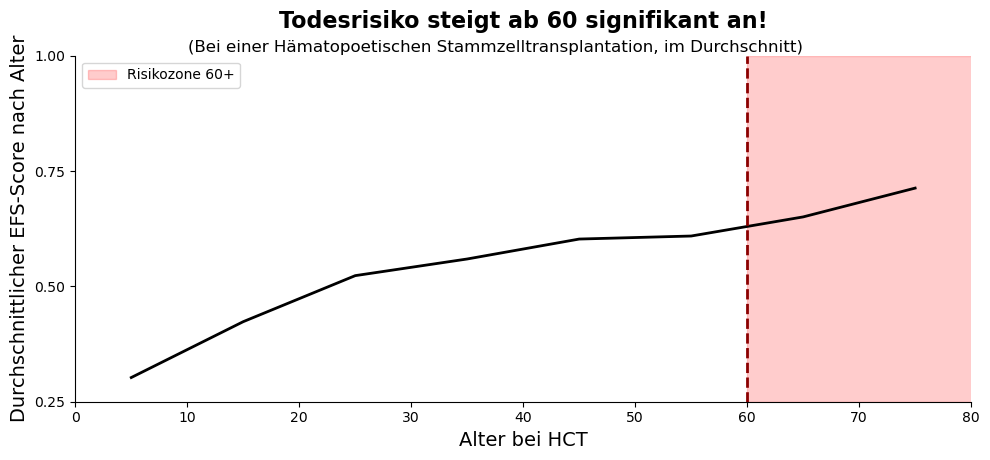

In [5]:
import matplotlib.pyplot as plt
import numpy as np

# Alter in 10-Jahres-Schritten und Durchschnittswerte berechnen
df_avg = df_train.groupby(pd.cut(df_train["age_at_hct"], bins=np.arange(0, 101, 10)))["efs"].mean().reset_index()
df_avg["age_mid"] = df_avg["age_at_hct"].apply(lambda x: x.mid)  # Mittelwert der Altersgruppen

plt.figure(figsize=(10, 5))

# Linie des durchschnittlichen Risiko-Scores je Altersgruppe
plt.plot(df_avg["age_mid"], df_avg["efs"], color="black", linewidth=2)

# Roter Bereich für Risikozone ab 60+
plt.axvspan(60, 100, color="red", alpha=0.2, label="Risikozone 60+")

# Dunkelroter Trennstrich bei 60
plt.axvline(x=60, color="darkred", linestyle="dashed", linewidth=2)

# Achseneinstellungen
plt.xticks(np.arange(0, 101, 10))  # 10-Jahres-Schritte
plt.yticks(np.linspace(0, 1, 5))  # Skala von 0 bis 1
plt.ylim(0.25 , 1)  # Score von 0 bis 1
plt.xlim(0, 80)  # Altersbereich 0-80

# Titel und Untertitel mit korrektem Abstand
plt.title("Todesrisiko steigt ab 60 signifikant an!", fontsize=16, fontweight="bold", pad=20)
plt.suptitle("(Bei einer Hämatopoetischen Stammzelltransplantation, im Durchschnitt)", 
             fontsize=12, y=0.85)  # y-Wert leicht über 1 setzen, um Abstand zu schaffen

plt.xlabel("Alter bei HCT", fontsize=14)
plt.ylabel("Durchschnittlicher EFS-Score nach Alter", fontsize=14)

# Rahmen und Gitter entfernen
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.grid(False)

# Legende für Risikozone
plt.legend()

plt.tight_layout()
plt.show()